# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Díaz Campos José Juan

**Professor**: Pablo Camarillo Ramirez

# Introduction

# **Problemática:**
Una tienda de comercio electrónico necesita analizar sus datos históricos de ventas para entender mejor el comportamiento de sus clientes y optimizar sus operaciones. Se requiere identificar qué productos son los más populares, cuáles clientes generan más ingresos y desde qué ubicaciones geográficas se realizan las compras
# **Solución Propuesta:**
Se implementará un pipeline de datos batch utilizando Apache Spark. Este pipeline procesará un dataset denormalizado (estilo Kaggle) que contiene detalles de ventas, incluyendo información del cliente y del producto en cada registro

# **Objetivo del Pipeline:**
El objetivo es limpiar, transformar y agregar estos datos para calcular métricas clave como las ventas totales por producto, el gasto acumulado por cliente y el número de transacciones por ciudad. Estos resultados permitirán a la tienda tomar decisiones informadas sobre inventario, marketing y estrategias de cliente.

# Dataset

# Modelo de Datos

Usaremos un esquema tabular denormalizado, parecido a un único CSV donde cada fila contiene información de la venta, el cliente y el producto. Es práctico para cargar rápido en un DataFrame de Spark y empezar a transformar los datos.

# Esquema de Datos

Cada registro (fila) tendrá este esquema (`StructType` en Spark):

* `venta_id`: `STRING` — Identificador único de la transacción
* `fecha`: `STRING` — Formato `YYYY-MM-DD`
* `cliente_id`: `STRING` — Identificador del cliente
* `nombre_cliente`: `STRING`
* `ciudad_cliente`: `STRING`
* `email_cliente`: `STRING`
* `producto_id`: `STRING` — Identificador del producto
* `nombre_producto`: `STRING`
* `categoria_producto`: `STRING`
* `precio_unitario`: `DOUBLE`
* `cantidad`: `INTEGER`
* `total_venta`: `DOUBLE` — Campo calculado: `precio_unitario * cantidad`

# Obtención del Dataset

Se generará de forma **sintética**. Se escribirá un script en Python que use la librería `Faker` para crear registros que sigan el esquema. El generador producirá un archivo CSV que luego será leído por Spark en la etapa de transformaciones.

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when, trim, count, isnull, concat_ws, avg, min as spark_min, max as spark_max, sum as spark_sum, date_format, hour
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType, ArrayType, DateType 
from pyspark.sql.functions import to_date, year, month 

from jjodiaz.spark_utils import SparkUtils
from jjodiaz.data_generator import EcommDataGenerator 

spark = SparkSession.builder \
    .appName("ProyectoFinalBatch_JoseJuanDiaz_Ecomm") \
    .master("local[*]") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

print("SparkSession iniciada correctamente.")

25/10/25 01:35:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


SparkSession iniciada correctamente.


In [2]:
## Data Loading

sales_schema = StructType([
    StructField("venta_id", StringType(), True),
    StructField("fecha", StringType(), True),
    StructField("cliente_id", StringType(), True),
    StructField("nombre_cliente", StringType(), True),
    StructField("ciudad_cliente", StringType(), True),
    StructField("email_cliente", StringType(), True),
    StructField("producto_id", StringType(), True),
    StructField("nombre_producto", StringType(), True),
    StructField("categoria_producto", StringType(), True),
    StructField("precio_unitario", DoubleType(), True),
    StructField("cantidad", IntegerType(), True),
    StructField("total_venta", DoubleType(), True)
])


input_csv_path = "/opt/spark/work-dir/data/generated_ecommerce_sales/"

df_ventas_raw = spark.read \
                .option("header", "true") \
                .schema(sales_schema) \
                .csv(input_csv_path)

# Transformations and Actions

In [3]:
# Transformations (40 points - Sin Acciones)

# 1. Limpieza básica y conversión de tipos
df_cleaned = df_ventas_raw \
    .withColumn("fecha", to_date(col("fecha"), "yyyy-MM-dd")) \
    .withColumn("nombre_cliente", trim(col("nombre_cliente"))) \
    .withColumn("ciudad_cliente", trim(col("ciudad_cliente"))) \
    .withColumn("nombre_producto", trim(col("nombre_producto"))) \
    .withColumn("categoria_producto", trim(col("categoria_producto"))) \
    .dropna(subset=["venta_id", "fecha", "cliente_id", "producto_id", "cantidad", "total_venta"])

# 2.1 Ventas totales por producto
df_ventas_por_producto = df_cleaned \
    .groupBy("producto_id", "nombre_producto", "categoria_producto") \
    .agg(
        spark_sum("total_venta").alias("ventas_totales_producto"),
        count("*").alias("numero_transacciones")
    )

# 2.2 Gasto total por cliente
df_gasto_por_cliente = df_cleaned \
    .groupBy("cliente_id", "nombre_cliente", "ciudad_cliente") \
    .agg(
        spark_sum("total_venta").alias("gasto_total_cliente"),
        count("*").alias("numero_compras")
    ) \
    .orderBy(col("gasto_total_cliente").desc())

# 2.3 Ventas por ciudad
df_ventas_por_ciudad = df_cleaned \
    .groupBy("ciudad_cliente") \
    .agg(
        spark_sum("total_venta").alias("ventas_totales_ciudad"),
        count("*").alias("numero_ventas_ciudad")
    ) \
    .orderBy(col("ventas_totales_ciudad").desc())

# DataFrame final seleccionado para persistir (ej. gasto por cliente)
df_final_to_persist = df_gasto_por_cliente

# Persistence Data

# Persistencia de datos 

He elegido **PostgreSQL** por las siguientes razones:

1. El resultado de las agregaciones (por ejemplo, gasto por cliente) es tabular y estructurado, lo que encaja bien con una base de datos relacional.
2. Los datos tienen un esquema claro y definido, ideal para el modelado relacional.
3. Las consultas que espero ejecutar son mayormente analíticas y estructuradas (p. ej. “Top 10 clientes por gasto”), y SQL ofrece el rendimiento y la expresividad necesarios para ese tipo de consultas.
4. Lo vimos en la clase, entonces me es más familiar.


In [4]:
# **Configuración de Conexión JDBC para PostgreSQL**
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
db_table_name = "gasto_cliente_ecomm_jjdc"
db_properties = {
    "user": "postgres",
    "password": "Admin@1234", 
    "driver": "org.postgresql.Driver"
}

try:
    df_final_to_persist.write \
        .format("jdbc") \
        .option("url", jdbc_url) \
        .option("dbtable", db_table_name) \
        .option("user", db_properties["user"]) \
        .option("password", db_properties["password"]) \
        .option("driver", db_properties["driver"]) \
        .mode("overwrite") \
        .save() 

    print(f"Datos de '{db_table_name}' persistidos correctamente en PostgreSQL.")

except Exception as e:
    print(f"Error al escribir en PostgreSQL: {e}")


Datos de 'gasto_cliente_ecomm_jjdc' persistidos correctamente en PostgreSQL.


# DAG

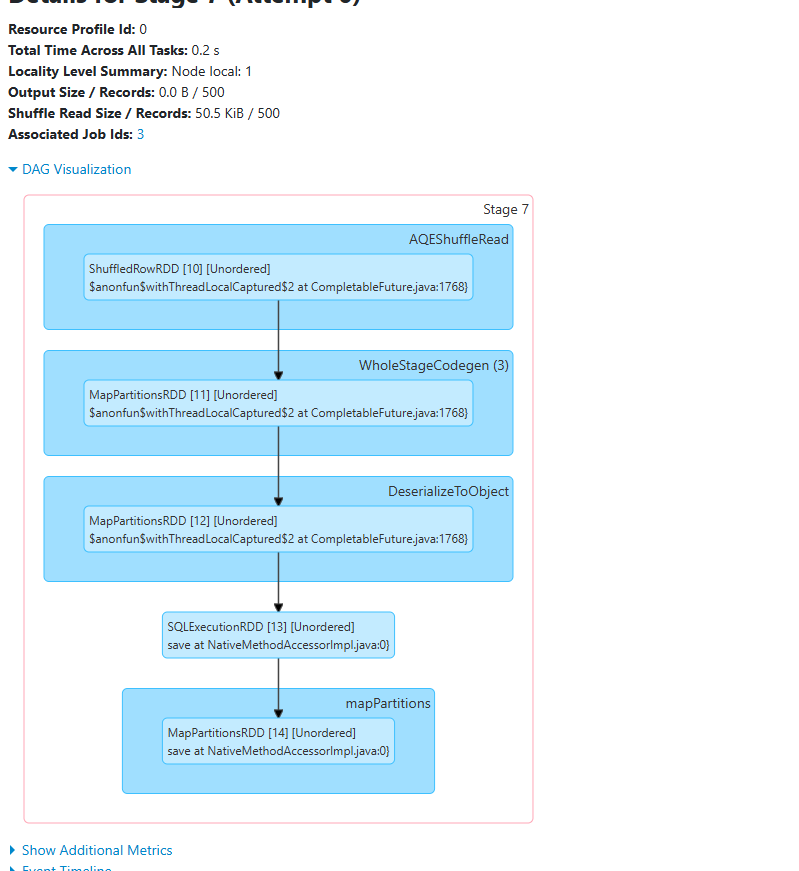